# Day2課題
car-consumeの線形回帰よりモデルの検証と正則化、前処理を行う。

項目  
* distance:走行距離  
* consume:車に表示される100Km当たりの消費燃料
* speed:走行時の平均速度  
* temp_inside:暖房の設定温度、NaNは暖房オフ  
* temp_outside:外気温  
* specials:特筆事項、以下の項目にホットエンコードとして存在している  
* gas_type:燃料の種類  
* AC:エアコンがACモードであるか(?)  
* rain:雨や雪が降っていた  
* sun:よく晴れていた  
* refill liters:給油した量
* refill gas:給油した種類

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

## 1. データの読み込み 

In [2]:
df_car_consume = pd.read_csv("car-consume/measurements.csv")[['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'specials', 'gas_type', 'AC', 'rain', 'sun', 'refill liters', 'refill gas']]

# データ
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


## 2. データの整理

### 2-1. 小数点の整形

In [3]:
# 文字列リプレイス
df_car_consume['distance'] = df_car_consume['distance'].str.replace(',', '.')
df_car_consume['consume'] = df_car_consume['consume'].str.replace(',', '.')
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].str.replace(',', '.')
df_car_consume['refill liters'] = df_car_consume['refill liters'].str.replace(',', '.')
# 数値にする
df_car_consume['distance'] = df_car_consume['distance'].astype(float)
df_car_consume['consume'] = df_car_consume['consume'].astype(float)
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].astype(float)
df_car_consume['refill liters'] = df_car_consume['refill liters'].astype(float)

### 2-2.ダミー変数の利用

In [4]:
# specialsはすでに別項目で存在しているのでドロップ
df_car_consume = df_car_consume.drop('specials', axis=1)

df_car_consume = pd.get_dummies(df_car_consume)

### 2-3.その他コンバート項目

In [5]:
# refill litersの欠損は給油無として0埋め
df_car_consume['refill liters'] = df_car_consume['refill liters'].fillna(0)

# 暖房のオンオフ判断
df_car_consume['heating_off'] = df_car_consume['temp_inside'].isnull().astype(int)

# temp_insideの欠損は暖房がオフのため外部気温と同じとみなしてtemp_outside代入
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].fillna(df_car_consume['temp_outside'])

# 内外の気温差
df_car_consume['temp_diff'] = df_car_consume['temp_inside'] - df_car_consume['temp_outside']

In [6]:
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,heating_off,temp_diff
0,28.0,5.0,26,21.5,12,0,0,0,45.0,1,0,1,0,0,9.5
1,12.0,4.2,30,21.5,13,0,0,0,0.0,1,0,0,0,0,8.5
2,11.2,5.5,38,21.5,15,0,0,0,0.0,1,0,0,0,0,6.5
3,12.9,3.9,36,21.5,14,0,0,0,0.0,1,0,0,0,0,7.5
4,18.5,4.5,46,21.5,15,0,0,0,0.0,1,0,0,0,0,6.5


## 3. データの分析

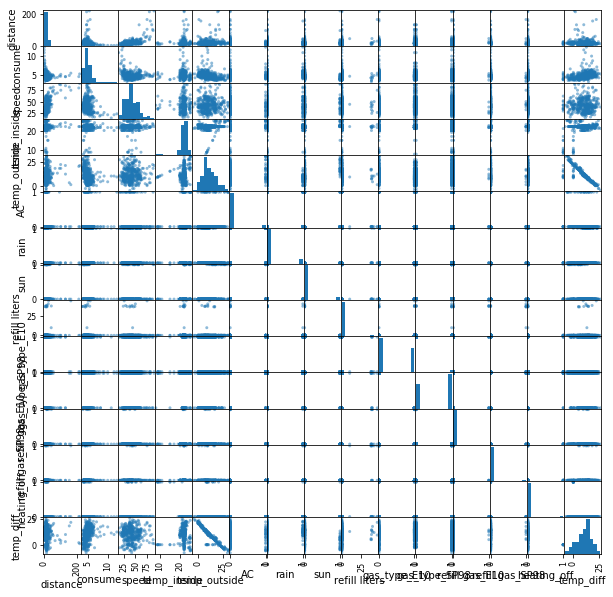

In [7]:
# 散布図行列
pd.plotting.scatter_matrix(df_car_consume, figsize=(10,10))
plt.show()

In [8]:
# 相関係数を確認
df_car_consume.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,gas_type_E10,gas_type_SP98,refill gas_E10,refill gas_SP98,heating_off,temp_diff
distance,1.000000,-0.128967,0.562299,0.072861,0.088175,-0.025738,-0.019791,0.081120,0.107045,0.053411,-0.053411,0.026079,0.106134,-0.035730,-0.066895
consume,-0.128967,1.000000,-0.227866,-0.035716,-0.320811,0.096591,0.248118,-0.170667,-0.074095,0.015327,-0.015327,-0.025731,-0.079080,-0.069953,0.313642
speed,0.562299,-0.227866,1.000000,0.026292,0.015411,-0.035408,0.009489,0.081618,-0.007446,0.097360,-0.097360,-0.073428,0.046177,-0.012205,-0.007539
temp_inside,0.072861,-0.035716,0.026292,1.000000,0.189519,0.182160,-0.010193,0.127052,0.016573,0.063965,-0.063965,0.009738,0.013224,-0.820054,0.114541
temp_outside,0.088175,-0.320811,0.015411,0.189519,1.000000,0.167562,-0.186315,0.346903,-0.041595,-0.148705,0.148705,-0.009135,-0.043809,0.014287,-0.953707
AC,-0.025738,0.096591,-0.035408,0.182160,0.167562,1.000000,0.242915,0.088598,-0.052571,-0.105285,0.105285,-0.033075,-0.042002,-0.051715,-0.113738
rain,-0.019791,0.248118,0.009489,-0.010193,-0.186315,0.242915,1.000000,-0.112650,0.033505,-0.060328,0.060328,0.026474,0.055653,-0.021909,0.185383
sun,0.081120,-0.170667,0.081618,0.127052,0.346903,0.088598,-0.112650,1.000000,-0.054448,-0.022761,0.022761,-0.034256,-0.043501,0.000558,-0.312066
refill liters,0.107045,-0.074095,-0.007446,0.016573,-0.041595,-0.052571,0.033505,-0.054448,1.000000,-0.000741,0.000741,0.640010,0.727194,-0.032443,0.047160
gas_type_E10,0.053411,0.015327,0.097360,0.063965,-0.148705,-0.105285,-0.060328,-0.022761,-0.000741,1.000000,-1.000000,0.136393,-0.121547,-0.058926,0.170045


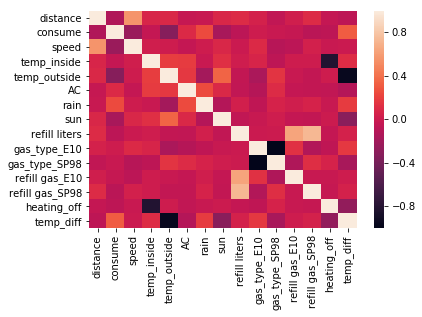

In [9]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_car_consume.corr())
plt.show()

## 4. 学習

交差法で確認する。  

以下の説明変数を学習対象から外す。
* temp_inside:暖房の設定温度であり単体ではパフォーマンスに関わらない  
* refill liters:単体での走行とは無関係
* refill gas:同上  

In [10]:
# 係数を求める
y = df_car_consume["consume"].values
X = df_car_consume[['distance', 'speed', 'temp_outside', 'gas_type_E10', 'AC', 'rain', 'sun', 'heating_off', 'temp_diff']].values

n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.672

Fold 2
MAE = 0.623

Fold 3
MAE = 0.739

Fold 4
MAE = 0.607

Fold 5
MAE = 0.52

Cross Validation MAE = 0.632


全データで学習して係数を確認する

In [11]:
# 係数を求める
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]
w9 = regr.coef_[8]

In [12]:
x1 = df_car_consume['distance'].values
x2 = df_car_consume['speed'].values
x3 = df_car_consume['temp_outside'].values
x4 = df_car_consume['gas_type_E10'].values
x5 = df_car_consume['AC'].values
x6 = df_car_consume['rain'].values
x7 = df_car_consume['sun'].values
x8 = df_car_consume['heating_off'].values
x9 = df_car_consume['temp_diff'].values

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3 + w4 * x4 + w5 * x5 + w6 * x6 + w7 * x7 + w8 * x8 + w9 * x9
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9))
print('二乗誤差 = {:.3f}'.format(squared_error))

w0 = 7.456, w1 = 0.002, w2 = -0.018, w3 = -0.106, w4 = 0.036, w5 = 0.442, w6 = 0.520, w7 = -0.134, w8 = -1.004, w9 = -0.066
二乗誤差 = 163.112


## 5.白色化

まずは無相関化

In [13]:
#  無相関化を行うための一連の処理
cov = np.cov(X, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
X_decorr = np.dot(S.T, X.T).T #データを無相関化

再度交差法実施

In [14]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_decorr, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.672

Fold 2
MAE = 0.623

Fold 3
MAE = 0.739

Fold 4
MAE = 0.607

Fold 5
MAE = 0.52

Cross Validation MAE = 0.632


In [15]:
# 係数を求める
regr = LinearRegression(fit_intercept=True)
regr.fit(X_decorr, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]
w9 = regr.coef_[8]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9))

w0 = 7.456, w1 = 0.007, w2 = -0.007, w3 = -0.037, w4 = -0.013, w5 = 0.079, w6 = 1.026, w7 = 0.647, w8 = 0.149, w9 = 0.086


係数が変わったが誤差は全く変わらない  
次に標準化

In [16]:
#  白色化を行うための一連の処理
stdsc = StandardScaler()
stdsc.fit(X_decorr)
X_whitening  = stdsc.transform(X_decorr) # 無相関化したデータに対して、さらに標準化

In [17]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_whitening, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.672

Fold 2
MAE = 0.623

Fold 3
MAE = 0.739

Fold 4
MAE = 0.607

Fold 5
MAE = 0.52

Cross Validation MAE = 0.632


In [18]:
# 係数を求める
regr = LinearRegression(fit_intercept=True)
regr.fit(X_whitening, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]
w9 = regr.coef_[8]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9))

w0 = 4.912, w1 = 0.171, w2 = -0.075, w3 = -0.360, w4 = -0.019, w5 = 0.038, w6 = 0.095, w7 = 0.218, w8 = 0.035, w9 = 0.022


やはり誤差については全くかわらない  
係数については波があったものから比較的フラットになっている

## 6.正則化

In [19]:
# 係数を求める
regr = Ridge(alpha=1e-5, random_state=1234)
regr.fit(X_whitening, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]
w9 = regr.coef_[8]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9))

w0 = 4.912, w1 = 0.171, w2 = -0.075, w3 = -0.360, w4 = -0.019, w5 = 0.038, w6 = 0.095, w7 = 0.218, w8 = 0.035, w9 = 0.022


変化なし

In [20]:
# 係数を求める
regr = Ridge(alpha=10, random_state=1234)
regr.fit(X_whitening, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]
w9 = regr.coef_[8]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9))

w0 = 4.912, w1 = 0.166, w2 = -0.073, w3 = -0.350, w4 = -0.018, w5 = 0.037, w6 = 0.092, w7 = 0.212, w8 = 0.034, w9 = 0.022


alphaを10にまで上げてみたら少しだけ変わった。

In [21]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_whitening, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = Ridge(alpha=10, random_state=1234)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Fold 1
MAE = 0.672

Fold 2
MAE = 0.626

Fold 3
MAE = 0.737

Fold 4
MAE = 0.606

Fold 5
MAE = 0.515

Cross Validation MAE = 0.631


MAEもわずかながら変わった